# Question 1 (b)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### To ignore any warning

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("parkingLot.csv")
df.head()

vehicle_no   timestamp             camera_id
0  MHUN7063     2024-09-12 05:00:00           1
1  MHYN4677     2024-09-12 05:00:00           1
2  MHEL6595     2024-09-12 05:00:00           1
3  MHNQ2590     2024-09-12 05:00:00           1
4  MHHA0518     2024-09-12 05:00:00           1

## Data preprocessing

- Converted time to datetime
- Removed unnecessary space from each record
- sorted the data according to timestamp

In [4]:
df['timestamp'] = df['timestamp           '].str.upper().astype('string')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['vehicle_no'] = df['vehicle_no '].str.strip()
df = df.drop('vehicle_no ', axis=1)
df = df.drop('timestamp           ', axis=1)
df = df.sort_values(by='timestamp')
df

camera_id           timestamp vehicle_no
0               1 2024-09-12 05:00:00   MHUN7063
21              1 2024-09-12 05:00:00   MHMY1867
20              1 2024-09-12 05:00:00   MHZF8417
19              1 2024-09-12 05:00:00   MHFU6425
18              1 2024-09-12 05:00:00   MHHB4038
...           ...                 ...        ...
106675          2 2024-11-14 00:00:00   MHEV1001
106674          2 2024-11-14 00:00:00   MHGL7893
106692          2 2024-11-14 00:00:00   MHQG5264
106682          2 2024-11-14 00:00:00   MHBB9719
106693          2 2024-11-14 00:00:00   MHLX0117

[106694 rows x 3 columns]

For this part, we removed the NAN values, because we just have to consider the average time spent on each day, so removing ~40 values from a single day which is out of ~800 values per day wont make much difference in the average time spent.

and for the values that were occured odd number of time each day, we paired them with the most matching string on each day

In [5]:
df['vehicle_no'] = df['vehicle_no'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106694 entries, 0 to 106693
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   camera_id   106694 non-null  int64         
 1   timestamp   106694 non-null  datetime64[ns]
 2   vehicle_no  106694 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.3+ MB


In [6]:
no_na_data = df[df['vehicle_no'] != '']
entries = no_na_data[no_na_data['camera_id']==1]
exits = no_na_data[no_na_data['camera_id']==2]
no_na_data

camera_id           timestamp vehicle_no
0               1 2024-09-12 05:00:00   MHUN7063
21              1 2024-09-12 05:00:00   MHMY1867
20              1 2024-09-12 05:00:00   MHZF8417
19              1 2024-09-12 05:00:00   MHFU6425
18              1 2024-09-12 05:00:00   MHHB4038
...           ...                 ...        ...
106675          2 2024-11-14 00:00:00   MHEV1001
106674          2 2024-11-14 00:00:00   MHGL7893
106692          2 2024-11-14 00:00:00   MHQG5264
106682          2 2024-11-14 00:00:00   MHBB9719
106693          2 2024-11-14 00:00:00   MHLX0117

[106253 rows x 3 columns]

#### Pairing the vehicle_no which are present in both entry and exit record

In [7]:
paired_data = pd.merge(entries, exits, on='vehicle_no', suffixes=('_entry', '_exit'))
paired_data = paired_data[paired_data['timestamp_entry'] < paired_data['timestamp_exit']]
paired_data

camera_id_entry     timestamp_entry vehicle_no  camera_id_exit  \
0                    1 2024-09-12 05:00:00   MHUN7063               2   
1                    1 2024-09-12 05:00:00   MHMY1867               2   
2                    1 2024-09-12 05:00:00   MHZF8417               2   
3                    1 2024-09-12 05:00:00   MHFU6425               2   
4                    1 2024-09-12 05:00:00   MHHB4038               2   
...                ...                 ...        ...             ...   
52755                1 2024-11-13 20:00:00   MHPN3450               2   
52756                1 2024-11-13 20:00:00   MHBB9719               2   
52757                1 2024-11-13 20:00:00   MHQJ4009               2   
52758                1 2024-11-13 20:00:00   MHDF3718               2   
52759                1 2024-11-13 20:00:00   MHVY8418               2   

           timestamp_exit  
0     2024-09-12 08:00:00  
1     2024-09-12 09:20:00  
2     2024-09-12 09:20:00  
3     2024-09-12 09:40:00  
4     2024-09-12 09:20:00  
...                   ...  
52755 2024-11-14 00:00:00  
52756 2024-11-14 00:00:00  
52757 2024-11-14 00:00:00  
52758 2024-11-14 00:00:00  
52759 2024-11-14 00:00:00  

[52578 rows x 5 columns]

#### Working on the records which are only present in only 1 of them

In [8]:
unmatched_entries = entries[~entries['vehicle_no'].isin(paired_data['vehicle_no'])]
unmatched_exits = exits[~exits['vehicle_no'].isin(paired_data['vehicle_no'])]

In [9]:
unmatched_entries['date'] = unmatched_entries['timestamp'].dt.date
unmatched_exits['date'] = unmatched_exits['timestamp'].dt.date

#### Iterating over each record in unmatched enteries to find the most similar unmatched exit on the same day. If similarity score > 0.75 then we are pairing them up.


In [10]:
from difflib import SequenceMatcher

orphan_pairs = []
for entry_idx, entry_row in unmatched_entries.iterrows():
    entry_date = entry_row['timestamp'].date()
    same_day_exits = unmatched_exits[unmatched_exits['timestamp'].dt.date == entry_date]

    if not same_day_exits.empty:
        
        similarities = same_day_exits['vehicle_no'].apply(lambda x: SequenceMatcher(None, entry_row['vehicle_no'], x).ratio())
        most_similar_exit_idx = similarities.idxmax()  
        
        if similarities[most_similar_exit_idx] > 0.75:
            exit_row = same_day_exits.loc[most_similar_exit_idx]
            if entry_row['timestamp'] < exit_row['timestamp']:  
                orphan_pairs.append({
                    'vehicle_no': entry_row['vehicle_no'],
                    'timestamp_entry': entry_row['timestamp'],
                    'timestamp_exit': exit_row['timestamp']
                })
            unmatched_exits = unmatched_exits.drop(most_similar_exit_idx)  


orphan_pairs_df = pd.DataFrame(orphan_pairs)
orphan_pairs_df

vehicle_no     timestamp_entry      timestamp_exit
0     MHHA0518 2024-09-12 05:00:00 2024-09-12 08:40:00
1     MHFT7338 2024-09-12 06:00:00 2024-09-12 10:40:00
2     MHPK8268 2024-09-12 09:00:00 2024-09-12 14:00:00
3     MHWY3805 2024-09-12 11:00:00 2024-09-12 14:20:00
4     MHIH5246 2024-09-12 11:40:00 2024-09-12 15:20:00
..         ...                 ...                 ...
495   MHNF6986 2024-11-13 10:00:00 2024-11-13 14:40:00
496   MHIO9771 2024-11-13 10:20:00 2024-11-13 16:00:00
497   MHZS7809 2024-11-13 10:40:00 2024-11-13 17:00:00
498   MHLE5669 2024-11-13 17:00:00 2024-11-13 22:40:00
499   MHDG8355 2024-11-13 18:40:00 2024-11-13 22:40:00

[500 rows x 3 columns]

#### Concatinating both paired dataset and the unpaired data set which we constructed. And sorting them again

In [11]:
final_data = pd.concat([paired_data[['vehicle_no', 'timestamp_entry', 'timestamp_exit']], orphan_pairs_df], ignore_index=True)
final_data = final_data.sort_values(by='timestamp_entry')
final_data

vehicle_no     timestamp_entry      timestamp_exit
0       MHUN7063 2024-09-12 05:00:00 2024-09-12 08:00:00
20      MHGS9163 2024-09-12 05:00:00 2024-09-12 08:00:00
19      MHZI0593 2024-09-12 05:00:00 2024-09-12 08:20:00
18      MHYN8096 2024-09-12 05:00:00 2024-09-12 08:40:00
17      MHJU1350 2024-09-12 05:00:00 2024-09-12 09:00:00
...          ...                 ...                 ...
52573   MHPN3450 2024-11-13 20:00:00 2024-11-14 00:00:00
52574   MHBB9719 2024-11-13 20:00:00 2024-11-14 00:00:00
52575   MHQJ4009 2024-11-13 20:00:00 2024-11-14 00:00:00
52576   MHDF3718 2024-11-13 20:00:00 2024-11-14 00:00:00
52577   MHVY8418 2024-11-13 20:00:00 2024-11-14 00:00:00

[53078 rows x 3 columns]

In [12]:
df = final_data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53078 entries, 0 to 52577
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   vehicle_no       53078 non-null  object        
 1   timestamp_entry  53078 non-null  datetime64[ns]
 2   timestamp_exit   53078 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 1.6+ MB


#### Duration is the time spent in the parking lot

In [13]:
df['duration'] = (df['timestamp_exit'] - df['timestamp_entry']).dt.total_seconds()
df

vehicle_no     timestamp_entry      timestamp_exit  duration
0       MHUN7063 2024-09-12 05:00:00 2024-09-12 08:00:00   10800.0
20      MHGS9163 2024-09-12 05:00:00 2024-09-12 08:00:00   10800.0
19      MHZI0593 2024-09-12 05:00:00 2024-09-12 08:20:00   12000.0
18      MHYN8096 2024-09-12 05:00:00 2024-09-12 08:40:00   13200.0
17      MHJU1350 2024-09-12 05:00:00 2024-09-12 09:00:00   14400.0
...          ...                 ...                 ...       ...
52573   MHPN3450 2024-11-13 20:00:00 2024-11-14 00:00:00   14400.0
52574   MHBB9719 2024-11-13 20:00:00 2024-11-14 00:00:00   14400.0
52575   MHQJ4009 2024-11-13 20:00:00 2024-11-14 00:00:00   14400.0
52576   MHDF3718 2024-11-13 20:00:00 2024-11-14 00:00:00   14400.0
52577   MHVY8418 2024-11-13 20:00:00 2024-11-14 00:00:00   14400.0

[53078 rows x 4 columns]

#### Grouping by each day

In [14]:

df['date'] = df['timestamp_entry'].dt.date
df_days = df.groupby('date')['duration'].mean()
df_days

date
2024-09-12    25392.808989
2024-09-13    61245.421245
2024-09-14    48343.843498
2024-09-15    56724.653740
2024-09-16    50038.588235
                  ...     
2024-11-09    18565.034965
2024-11-10    17167.372881
2024-11-11    16836.231884
2024-11-12    17394.044665
2024-11-13    18739.052497
Name: duration, Length: 63, dtype: float64

#### Plotting the data 

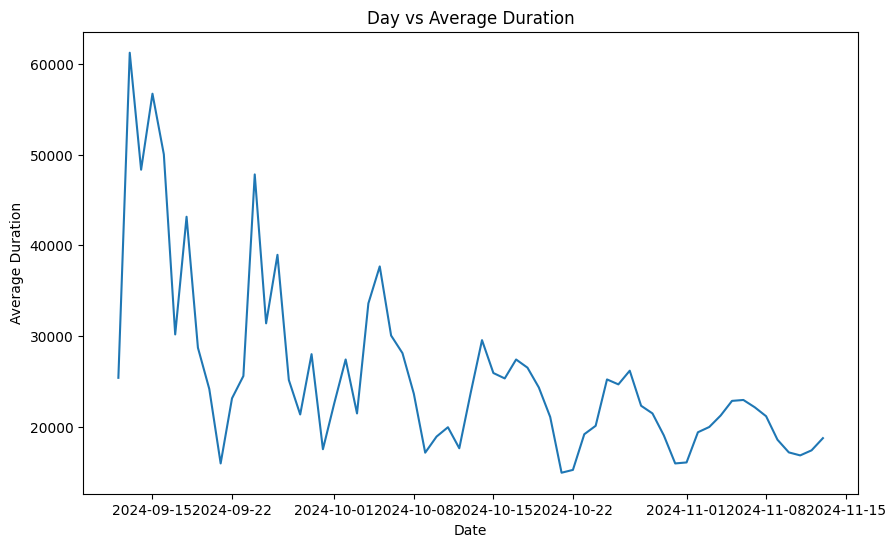

In [15]:

plt.figure(figsize=(10, 6))
plt.plot(df_days.index, df_days.values)
plt.xlabel('Date')
plt.ylabel('Average Duration')
plt.title('Day vs Average Duration')
plt.show()


### Auto correlation plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

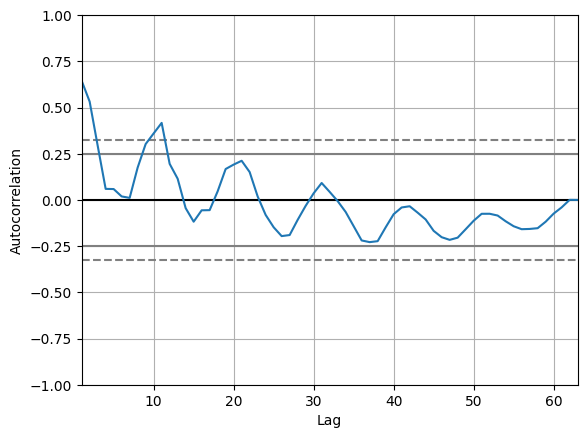

In [8]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_days)

### Scaling the data

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_days.values.reshape(-1, 1))
scaled_data = pd.DataFrame(scaled_values, columns=['avg_duration'])
scaled_data.index = df_days.index
scaled_data


avg_duration
date                    
2024-09-12      0.225978
2024-09-13      1.000000
2024-09-14      0.721468
2024-09-15      0.902401
2024-09-16      0.758056
...                  ...
2024-11-09      0.078574
2024-11-10      0.048399
2024-11-11      0.041250
2024-11-12      0.053293
2024-11-13      0.082330

[63 rows x 1 columns]

From the autocorrelation plot, we trained the model on the following parameters

- (2,1,1)
- (1,1,2)
- (1,1,1)

In [17]:
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

X = scaled_data.values
size = int(len(X) * 0.7)
train, test  = X[0:size], X[size:len(X)]

history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(2,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    temp  = output[0]
    predictions1.append(temp)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions1))

history = [x for x in train]
predictions2 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(1,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    temp  = output[0]
    predictions2.append(temp)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions2))

history = [x for x in train]
predictions3 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    temp  = output[0]
    predictions3.append(temp)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions3))



0.04137481725965473
0.06479427644012847
0.04262635734239042


### Unscaling the predictions

In [21]:
unscaled_predictions = scaler.inverse_transform(np.array(predictions1).reshape(-1, 1))
unscaled_test = scaler.inverse_transform(test)
unscaled_train = scaler.inverse_transform(train)


### Plot between predictions and actual data

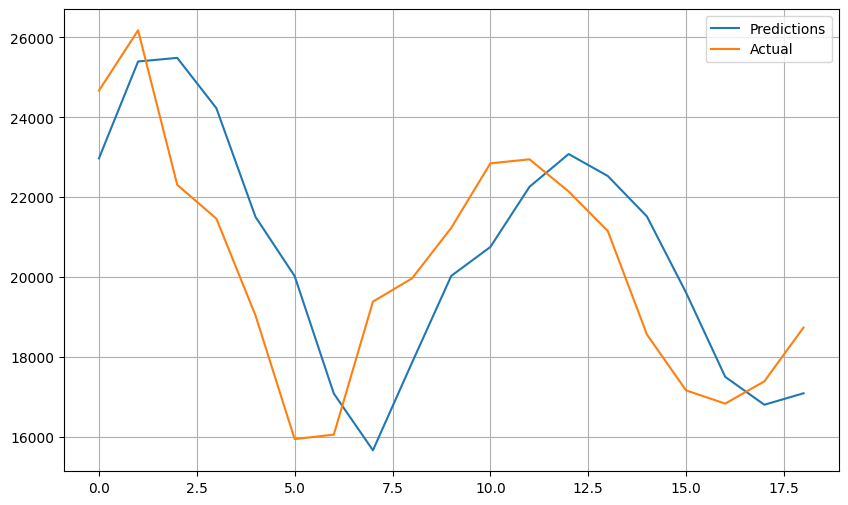

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(unscaled_predictions, label='Predictions')
plt.plot(unscaled_test, label='Actual')
plt.grid(True)
plt.legend()
plt.show()

In [20]:
def MASE(y_true, y_pred, y_train):
    mae = mean_absolute_error(y_true, y_pred)
    naive_forecast = np.roll(y_train, 1)[1:]  
    naive_mae = mean_absolute_error(y_train[1:], naive_forecast)
    mase = mae / naive_mae
    return mase

In [23]:
from sklearn.metrics import mean_absolute_percentage_error
print("MAPE: ", mean_absolute_percentage_error(unscaled_test, unscaled_predictions)*100)
print("MASE: ", MASE(unscaled_test.reshape(1, -1)[0], unscaled_predictions.reshape(1, -1)[0], unscaled_train.reshape(-1,1)))


MAPE:  9.81429557710239
MASE:  0.26311286911247267


### Forecast for next 

In [29]:
# Use this model to predict the next 7 days

forecast_steps = 7
history = np.array([x.flatten() for x in history])  # Ensure history is a list of 1-dimensional arrays
model = sm.tsa.arima.ARIMA(history, order=(2,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=forecast_steps)

# Inverse transform the forecasted values
unscaled_forecast = scaler.inverse_transform(forecast.reshape(-1, 1))
unscaled_forecast

array([[19672.40264779],
       [20047.22669476],
       [19846.20302692],
       [19971.56096385],
       [19898.22616303],
       [19942.27460852],
       [19916.10701155]])